In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from sklearn.naive_bayes import GaussianNB, ComplementNB, CategoricalNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # for train-test split 
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.model_selection import GridSearchCV # for fine-tuning
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve # for evaluation
from sklearn.pipeline import make_pipeline # for prediction

In [3]:
# for Generator
from scipy import stats # for sampling
from fitter import Fitter # for fitting the best distribution
import copy # for copying nested dictionaries

In [4]:
import matplotlib.pyplot as plt  # for visualization 
import seaborn as sns  # for coloring 

# set style of graphs
plt.style.use('seaborn')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 80

In [5]:
train_data = pd.read_csv('../dataset/train_data.csv')

In [6]:
feature_list = list(train_data.columns)
feature_list

['GAME_DATE_EST',
 'GAME_ID',
 'GAME_STATUS_TEXT',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'TEAM_ID_home',
 'PTS_home',
 'FG_PCT_home',
 'FT_PCT_home',
 'FG3_PCT_home',
 'AST_home',
 'REB_home',
 'TEAM_ID_away',
 'PTS_away',
 'FG_PCT_away',
 'FT_PCT_away',
 'FG3_PCT_away',
 'AST_away',
 'REB_away',
 'HOME_TEAM_WINS']

In [7]:
#✍To predict win/loss of a game, we can use one of the two ways:

#1. Select only one feature (points), the win/loss prediction is just based on which team has the higher point.
#2. Select features other than points, the win/loss is then based on the prediction of a classifier which takes those features as inputs.

# In this notebook, we will use option (2) as it offers better range of uncertainty for simulation.

selected_features = [
    'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
    'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
    ]

# check the features we selected
X = train_data[selected_features]
X.head()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
0,0.409,0.929,0.308,32.0,56.0,0.372,0.737,0.375,22.0,31.0
1,0.446,0.611,0.400,30.0,58.0,0.403,0.818,0.381,20.0,36.0
2,0.470,0.800,0.333,25.0,38.0,0.488,0.724,0.385,20.0,44.0
3,0.389,0.947,0.238,26.0,54.0,0.395,0.895,0.364,20.0,34.0
4,0.466,0.792,0.500,29.0,42.0,0.430,0.750,0.450,15.0,37.0


In [8]:
y = train_data['HOME_TEAM_WINS']
y.head()

0    1
1    1
2    0
3    1
4    1
Name: HOME_TEAM_WINS, dtype: int64

In [9]:
X = X.to_numpy()
y = y.to_numpy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X shape", X_train.shape, "y shape", y_train.shape)

X shape (19256, 10) y shape (19256,)


##### Utility function

In [11]:
def evaluate(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    # print(f"accuracy: {accuracy_score(y_test, y_pred)}")
    # print(f"AUC: {roc_auc_score(y_test, y_pred)}")
    # print(f"log_loss: {log_loss(y_test, y_pred)}")

## 1. SVM

In [12]:
# for SVM a scaler it can improve accuracy of the model

# scaler = StandardScaler() # initialize an instance 
# X_train_svm = scaler.fit_transform(X_train)

In [13]:
%%time 

# train SVM

support_vector_default = SVC() # initialize a model
support_vector_default.fit(X_train, y_train) # fit(train) it with the training data and targets

# check test score 
y_pred_svm_default = support_vector_default.predict(X_test) 

CPU times: user 9.72 s, sys: 23.2 ms, total: 9.74 s
Wall time: 9.74 s


#### Grid search SVM

In [14]:
%%time 

# fine-tuning hyperparameters
#param_grid_svm = {'C': [0.1, 1, 10],
#              'gamma': [1, 0.5, 0.1, 0.01, 0.001, 0.0001],
#              'kernel': ['linear', 'poly', 'sigmoid', 'rbf']
#            }
param_grid_svm = {'C': [0.1],
              'gamma': [0.1],
              'kernel': ['linear', 'poly', 'rbf']
            }

grid_search_svm = GridSearchCV(estimator=support_vector_default, param_grid=param_grid_svm, cv=10, verbose=2, scoring='accuracy', 
                            n_jobs = -1, return_train_score=True)

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 29.6 µs


In [15]:
# grid_search_svm.fit(X_train, y_train)

In [16]:
# grid_search_svm.best_params_

# {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

In [17]:
%%time 

# train SVM

support_vector = SVC(C=0.1, gamma=0.1, kernel='linear') # initialize a model
support_vector.fit(X_train, y_train) # fit(train) it with the training data and targets

# check test score 
y_pred_svm = support_vector.predict(X_test) 

CPU times: user 8.3 s, sys: 74.2 ms, total: 8.38 s
Wall time: 8.37 s


## 2. Random Forest

In [18]:
#Create a Gaussian Classifier
random_forest_default = RandomForestClassifier()

# clf = RandomForestClassifier(n_estimators=20, random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_forest_default.fit(X_train,y_train)

y_pred_rf_default = random_forest_default.predict(X_test)

#### Grid Search Random Forest

In [19]:
# another round

param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50],
    'bootstrap': [True, False]
    }

# Create a base model
grid_search_rf = GridSearchCV(estimator=random_forest_default, param_grid=param_grid_rf, cv=10, verbose=2, scoring='accuracy', 
                            n_jobs = -1, return_train_score=True)

In [20]:
# grid_search_rf.fit(X_train, y_train)

In [21]:
# grid_search_rf.best_params_

# {'bootstrap = True', max_depth = 30, max_features = 'auto', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 400}

In [22]:
#Create a Gaussian Classifier
# random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=30, bootstrap='True')
random_forest = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_depth=50, bootstrap='True')
# clf = RandomForestClassifier(n_estimators=20, random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_forest.fit(X_train,y_train)

y_pred_rf = random_forest.predict(X_test)

## 3. Naive Bayes

In [23]:
gauss_nb_default = GaussianNB()
gauss_nb_default.fit(X_train, y_train)
y_pred_gauss_nb_default = gauss_nb_default.predict(X_test)

#### Grid search Naive Bayes

In [24]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
    }

In [25]:
grid_search_nb = GridSearchCV(estimator=gauss_nb_default, param_grid=param_grid_nb, cv=10, verbose=2, scoring='accuracy', 
                            n_jobs = -1, return_train_score=True)

In [26]:
# grid_search_nb.fit(X_train, y_train)

In [27]:
# grid_search_nb.best_params_

In [28]:
gauss_nb = GaussianNB(var_smoothing=1.873817422860383e-07)
gauss_nb.fit(X_train, y_train)
y_pred_gauss_nb = gauss_nb.predict(X_test)

### Metrics

/home/silviobaratto/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/silviobaratto/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/silviobaratto/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_

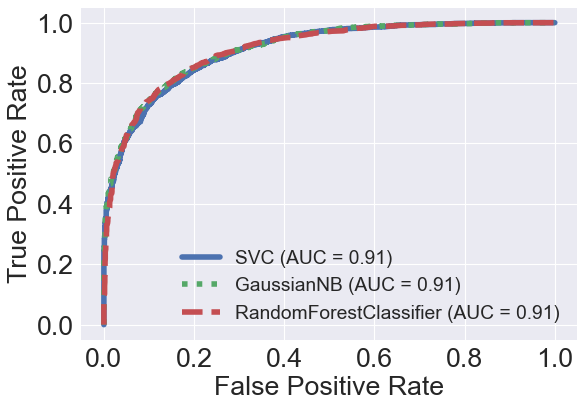

In [29]:
fig = plot_roc_curve(support_vector, X_test, y_test, linewidth=5, linestyle = '-')
fig = plot_roc_curve(gauss_nb, X_test, y_test, ax = fig.ax_, linewidth=5, linestyle = ':')
fig = plot_roc_curve(random_forest, X_test, y_test, ax = fig.ax_, linewidth=5, linestyle = '--')

plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)

plt.legend(fontsize=24) # using a size in points
plt.legend(fontsize="xx-large") # using a named size

plt.savefig('../report/plots/auc_optimize.png')

/home/silviobaratto/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/silviobaratto/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/silviobaratto/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_

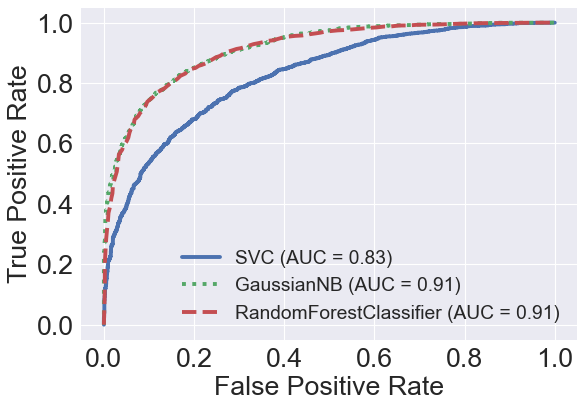

In [30]:
fig = plot_roc_curve(support_vector_default, X_test, y_test, linewidth=3.5, linestyle = '-')
fig = plot_roc_curve(gauss_nb_default, X_test, y_test, ax = fig.ax_, linewidth=3.5, linestyle = ':')
fig = plot_roc_curve(random_forest_default, X_test, y_test, ax = fig.ax_, linewidth=3.5, linestyle = '--')

plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)

plt.legend(fontsize=24) # using a size in points
plt.legend(fontsize="xx-large") # using a named size

plt.savefig('../report/plots/auc_default.png')

In [31]:
evaluate(y_test, y_pred_rf_default)
evaluate(y_test, y_pred_svm_default)
evaluate(y_test, y_pred_gauss_nb_default)

[[1544  411]
 [ 409 2451]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1955
           1       0.86      0.86      0.86      2860

    accuracy                           0.83      4815
   macro avg       0.82      0.82      0.82      4815
weighted avg       0.83      0.83      0.83      4815

[[1215  740]
 [ 479 2381]]
              precision    recall  f1-score   support

           0       0.72      0.62      0.67      1955
           1       0.76      0.83      0.80      2860

    accuracy                           0.75      4815
   macro avg       0.74      0.73      0.73      4815
weighted avg       0.74      0.75      0.74      4815

[[1562  393]
 [ 426 2434]]
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1955
           1       0.86      0.85      0.86      2860

    accuracy                           0.83      4815
   macro avg       0.82      0.83      0.82    

In [32]:
evaluate(y_test, y_pred_rf)
evaluate(y_test, y_pred_svm)
evaluate(y_test, y_pred_gauss_nb)

[[1538  417]
 [ 391 2469]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1955
           1       0.86      0.86      0.86      2860

    accuracy                           0.83      4815
   macro avg       0.83      0.82      0.83      4815
weighted avg       0.83      0.83      0.83      4815

[[1496  459]
 [ 371 2489]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1955
           1       0.84      0.87      0.86      2860

    accuracy                           0.83      4815
   macro avg       0.82      0.82      0.82      4815
weighted avg       0.83      0.83      0.83      4815

[[1562  393]
 [ 425 2435]]
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1955
           1       0.86      0.85      0.86      2860

    accuracy                           0.83      4815
   macro avg       0.82      0.83      0.82    

### 3. Fitting a Generator

In [33]:
# Like before, we had held out data from 2019-2020 playoff for real testing
# Though large data is essential for fitting, for time-series problems, we give priority to the recent data most reflective of team's recent ability.
# Since we aim to predict 2019-2020 playoff, here we will just fit the data from that regular session which starts in Oct, 2019.

df_ = train_data.loc[train_data['SEASON'] > 2019].reset_index(drop=True)

In [34]:
selected_distributions = [
    'norm','t', 'f', 'chi', 'cosine', 'alpha', 
    'beta', 'gamma', 'dgamma', 'dweibull',
    'maxwell', 'pareto', 'fisk'
    ]

In [35]:
unique_teams = train_data['HOME_TEAM_ID'].unique() # extract all the unique teams

# Since we don't care about whether the team was a host or visitor in each game, 
# we can just combine the features for all games.

# Get all the data for teams
all_team_sim_data = {}

for team_name in unique_teams:
    
    # find games where the team is either the host or guest
    df_team = df_.loc[(df_['HOME_TEAM_ID'] == team_name) | (df_['VISITOR_TEAM_ID'] == team_name)]
    # it is home team, select the first 5 features
    df_1 = df_team.loc[df_team['HOME_TEAM_ID'] == team_name][selected_features[:5]]
    # it is guest team, select the first 5 features
    df_0 = df_team.loc[df_team['VISITOR_TEAM_ID'] == team_name][selected_features[5:]]

    # combine them
    df_0.columns = df_1.columns # before concating, match the column names
    df_s = pd.concat([df_1, df_0], axis = 0)
    
    # convert the pandas.DataFrame to numpy array
    all_team_sim_data[team_name] = df_s.to_numpy()


In [36]:
all_team_sim_data

{'Timberwolves': array([[ 0.395,  0.75 ,  0.371, 17.   , 51.   ],
        [ 0.402,  0.719,  0.275, 20.   , 47.   ],
        [ 0.432,  0.857,  0.268, 25.   , 48.   ],
        [ 0.432,  0.857,  0.268, 25.   , 48.   ],
        [ 0.477,  0.571,  0.361, 17.   , 43.   ],
        [ 0.518,  0.688,  0.323, 30.   , 36.   ],
        [ 0.5  ,  0.647,  0.5  , 29.   , 53.   ],
        [ 0.42 ,  0.826,  0.346, 19.   , 52.   ],
        [ 0.433,  0.833,  0.243, 27.   , 48.   ],
        [ 0.424,  0.643,  0.429, 25.   , 43.   ],
        [ 0.43 ,  0.833,  0.25 , 30.   , 40.   ],
        [ 0.429,  0.811,  0.353, 23.   , 50.   ],
        [ 0.427,  0.778,  0.303, 20.   , 38.   ],
        [ 0.451,  0.733,  0.4  , 24.   , 34.   ],
        [ 0.432,  0.789,  0.366, 29.   , 43.   ],
        [ 0.419,  0.769,  0.471, 26.   , 38.   ],
        [ 0.421,  0.92 ,  0.375, 37.   , 44.   ],
        [ 0.386,  0.727,  0.237, 24.   , 43.   ],
        [ 0.376,  0.875,  0.229, 21.   , 44.   ],
        [ 0.406,  0.833,  0.225, 2

In [37]:
# data format:
#   team_name => list of feature distributions => dictionary with distribution name and parameters
#   e.g.,
#   megadata = {
      #'Timberwolves': [{'beta': (0.23, 0.3, 0.3, 0.4)}, {'nor': (0.23, 0.3,)}, ..], 
      #'Warriors':[{}, {},...]
      #  }
    
megadata = {} # store the data that our Generator will rely on
for team_name in unique_teams:
    
    feature_dis_paras = []
    data = all_team_sim_data[team_name]
    
    # 5 features for each team
    for i in range(5): 
        f = Fitter(data[:, i]) # initalize a Fitter instance
        f.distributions = selected_distributions # use only the selected distributions (faster)
        f.fit() # do the fitting 
        best_paras = f.get_best(method='sumsquare_error') # get the best fitted paras
        feature_dis_paras.append(best_paras)
        
    megadata[team_name] = feature_dis_paras
    
# print('Features for all teams have been fitted!')

### 4. Simulation

In [38]:
DATA = megadata.copy() # data that Generator must rely on

GEN = {
 'alpha': stats.alpha.rvs,
 'beta': stats.beta.rvs,
 'chi': stats.chi.rvs,
 'cosine': stats.cosine.rvs,
 'dgamma': stats.dgamma.rvs,
 'dweibull':stats.dweibull.rvs,
 'f':stats.f.rvs,
 'fisk':stats.fisk.rvs,
 'gamma': stats.gamma.rvs,
 'maxwell':stats.maxwell.rvs,
 'norm':stats.norm.rvs,
 'pareto':stats.pareto.rvs,
 't':stats.t.rvs,
}

In [50]:
# feature scaler + fine-turned SVM 
# DIS = make_pipeline(scaler, support_vector)
#DIS = make_pipeline(random_forest)
DIS = make_pipeline(gauss_nb)

Process: 

1. sampling: "generate feature values used for making win/loss prediction"
2. predict: "predict the win or loss of  n game(s) played by two tems"

In [40]:
class Game:
    
    '''
    
    A game between two teams:
    
    - feature values sampled from Generator
    - win/loss predicted by Discriminator
    
    '''
    
    def __init__ (self, random_state = None):
        
        self.random_state = random_state # keep this to None for making simulations 
    
    def predict(self, team1, team2, num_games = 1):
        
        ''' predict the win or loss of  n game(s) played by two tems'''
        
        assert num_games >= 1, "at least one game must be played"
        # output numpy array
        team_1_feature_data = DATA[team1]
        team_2_feature_data = DATA[team2]
        
        features = []
        for feature_paras_1 in team_1_feature_data:
            sample_1 = self.sampling(feature_paras_1, size = num_games) # gives a list if num_games> 1
            features.append(sample_1) 
            
        for feature_paras_2 in team_2_feature_data:
            sample_2 = self.sampling(feature_paras_2, size = num_games) # gives a list if num_games> 1
            features.append(sample_2)
            
        features = np.array(features).T 
        win_loss = DIS.predict(features)
        # print(f"team_1: {team1}, team_2: {team2}, win_loss: {list(win_loss)}")
        
        return list(win_loss) # a list of win/loss from num_games
    
    
    def sampling(self, dic, size = 1, random_state = None):
        
        '''generate feature values used for making win/loss prediction'''
                        
        dis_name = list(dic.keys())[0] # get the type
        paras = list(dic.values())[0] # get the paras
    
        # get sample
        sample = GEN[dis_name](*paras, size = size,  random_state =  random_state)
        
        return sample

Process:

1. play_n_games: "simulate data, and then use our classifier to predict win/loss"
2. play_round: "play a round of games based of a list of paired teams"
3. one_time_sim: "simulate the entire playoff once and also record the accumulated wins"
4. simulate: "simulate the entire playoff n times and also record the accumulated wins"

In [41]:
class FinalTournament(Game):
    
    ''' Best-of-7 elimination, 16 teams, 4 rounds in total to win championship '''
    
    def __init__(self, n_games_per_group = 7, winning_threshold = 4, random_state = None):

        self.n_games_per_group  = n_games_per_group
        self.winning_threshold = winning_threshold
        self.team_list = None
        self.rounds = {} # keep track the number of times a team wins at each round 
        super().__init__(random_state)
        
    
    def simulate(self, group_list, n_simulation = 1, probs = True):
        
        ''' simulate the entire playoff n times and also record the accumulated wins'''
             
        # update the list of teams
        self.rounds = {}
        self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        
        for i in range(n_simulation):
            # print(f"epoch number: {i}")
            cham = self.one_time_simu(group_list)
        if probs:
            self.rounds_probs = self._compute_probs()
            
    
    def one_time_simu(self, group_list, verbose = False, probs = False):
        
        ''' simulate the entire playoff once and also record the accumulated wins'''
        
        # update the list of teams if haven't done so
        if self.team_list == None: 
            self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        round_number, done = 0, 0
        while not done: 
            all_group_winners, group_list = self.play_round(group_list)
            # retrive round stats
            try:
                updated_round_stats = self.rounds[round_number]
            except KeyError:
                updated_round_stats = {}
                for team in self.team_list:
                    updated_round_stats[team] = 0
            # if a team wins, record + 1 
            for winner in all_group_winners:
                try: 
                    updated_round_stats[winner] += 1
                except KeyError:
                    pass     
            self.rounds[round_number] = updated_round_stats
            if verbose:
                print('{} round played'.format(round_number))
            if probs:
                self.rounds_probs = self._compute_probs()
            if type(group_list) != list: # if it becomes the final
                done = 1
            round_number += 1
            
        return group_list

        
    def play_round(self, group_list):
        
        '''play a round of games based of a list of paired teams'''
        
        all_group_winners = [] 
        # play each group and get the group winner
        for group in group_list:
            winner = self.play_n_games(group[0], group[1])
            all_group_winners.append(winner)
        
        if len(all_group_winners) > 1:
            new_group_list = []         
            for index in range(0, len(all_group_winners), 2):
                # first winner, second winner
                new_group = [all_group_winners[index], all_group_winners[index + 1]]
                new_group_list.append(new_group)
                
            return all_group_winners, new_group_list
        else:  
            return all_group_winners, winner
        
        
    def play_n_games(self, team1, team2):
        
        
        '''simulate data, and then use our classifier to predict win/loss'''
        result = Game().predict(team1, team2, self.n_games_per_group)
        if sum(result[:4]) == self.winning_threshold or sum(result) >= self.winning_threshold:
            winner = team1 # home team wins
        else:
            winner = team2 # visitor team wins
            
        return winner
    
    def rounds_list(self):
        list_round = self.rounds
        return list
    
    def _compute_probs(self):
        
        '''prob = wins for a team / sum of wins for all teams at a particular round'''
        
        rounds_probs = copy.deepcopy(self.rounds)
        for round_number, round_stats in rounds_probs.items():
            m = np.sum(list(round_stats.values()))
            for k, v in rounds_probs[round_number].items():
                rounds_probs[round_number][k] = v / m
                
        return rounds_probs

In [42]:
game = Game()
team1 = 'Bucks'
team2 = 'Suns'
result = game.predict('Bucks', 'Suns', 7)
if sum(result[:4]) == 4 or sum(result) >= 4:
    print(team1, " wins ")
else:
    print(team2, " wins ")

Suns  wins 


In [43]:
#2021
group_list_2021 = [
     # Eastern Conference
     ('76ers', 'Wizards'),  # group A 1 
     ('Knicks', 'Hawks'), # group B 4 
    
     ('Bucks', 'Heat'), # group C 3 
     ('Nets', 'Celtics'), # group D 2
    
     # Western Conference
     ('Jazz','Grizzlies'),  # group E 1 
     ('Clippers','Mavericks'), # group F 4 
    
     ('Nuggets', 'Trail Blazers'), # group G 3 
     ('Suns', 'Lakers')] # group H 2

In [44]:
#2022
group_list_2022 = [
     # Eastern Conference
     ('Heat', 'Hawks'),  # group A 1 
     ('76ers', 'Raptors'), # group B 4 
    
     ('Bucks', 'Bulls'), # group C 3 
     ('Celtics', 'Nets'), # group D 2
    
     # Western Conference
     ('Suns','Pelicans'),  # group E 1 
     ('Mavericks','Jazz'), # group F 4 
    
     ('Warriors', 'Nuggets'), # group G 3 
     ('Grizzlies', 'Timberwolves')] # group H 2

In [51]:
%%time

# initiate a playoff
playoff = FinalTournament()

# simulate the playoff 5,000 times

playoff.simulate(group_list_2022, n_simulation = 5000)


CPU times: user 45.9 s, sys: 3.46 ms, total: 45.9 s
Wall time: 45.9 s


In [52]:
playoff.rounds_probs

{0: {'Heat': 0.074525,
  '76ers': 0.109925,
  'Bucks': 0.095075,
  'Celtics': 0.023,
  'Suns': 0.089425,
  'Mavericks': 0.034725,
  'Warriors': 0.0544,
  'Grizzlies': 0.11025,
  'Hawks': 0.050475,
  'Raptors': 0.015075,
  'Bulls': 0.029925,
  'Nets': 0.102,
  'Pelicans': 0.035575,
  'Jazz': 0.090275,
  'Nuggets': 0.0706,
  'Timberwolves': 0.01475},
 1: {'Heat': 0.09115,
  '76ers': 0.09665,
  'Bucks': 0.1234,
  'Celtics': 0.0054,
  'Suns': 0.1426,
  'Mavericks': 0.00745,
  'Warriors': 0.0714,
  'Grizzlies': 0.0653,
  'Hawks': 0.0575,
  'Raptors': 0.0047,
  'Bulls': 0.0266,
  'Nets': 0.0946,
  'Pelicans': 0.04905,
  'Jazz': 0.0509,
  'Nuggets': 0.11075,
  'Timberwolves': 0.00255},
 2: {'Heat': 0.0477,
  '76ers': 0.0511,
  'Bucks': 0.1903,
  'Celtics': 0.0036,
  'Suns': 0.191,
  'Mavericks': 0.0044,
  'Warriors': 0.0487,
  'Grizzlies': 0.0414,
  'Hawks': 0.0303,
  'Raptors': 0.0008,
  'Bulls': 0.03,
  'Nets': 0.1462,
  'Pelicans': 0.0543,
  'Jazz': 0.0498,
  'Nuggets': 0.1101,
  'Timberwo

### 5. Visualization & Analysis

In [47]:
def plotting(rounds_data):
    
    rounds_stats = list(rounds_data.values())
    team_names = list(rounds_stats[0].keys())
    
    # x is number of rounds used for labels, y is a 2-D array of (n_teams, n_rounds) used for data
    x = list(rounds_data.keys())
    y = np.array([list(r.values()) for r in rounds_stats]).T 
    
    # we need at least 16 different colors, one for each team
    c_1 =  sns.color_palette('tab10', n_colors = 10)
    c_2 =  sns.color_palette("pastel", n_colors = 10)
    color_map = c_1 + c_2 
    
    fig = plt.figure()
    plt.stackplot(x, y, labels = team_names, colors = color_map) 
    plt.legend(bbox_to_anchor=(1.1, 1.1), loc = 'upper left', fontsize=13)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Round Number', fontsize = 15)
    plt.title('Winning probabilities by all Teams & Rounds', pad = 20, fontsize = 24)
    plt.tight_layout()
    plt.show()
    
    return fig

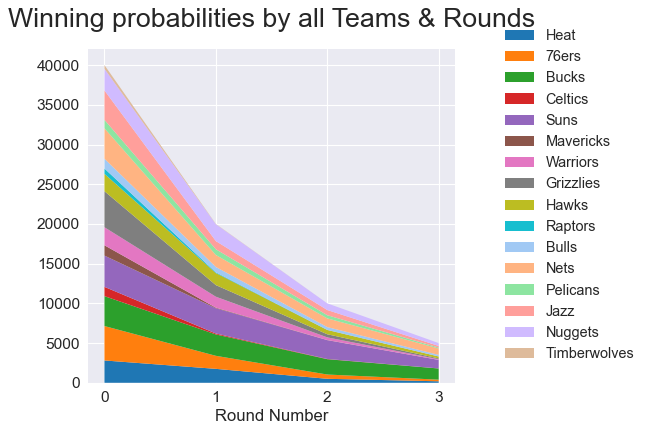

In [48]:
# check that a team's wins should get less and less in later rounds
fig = plotting(playoff.rounds)

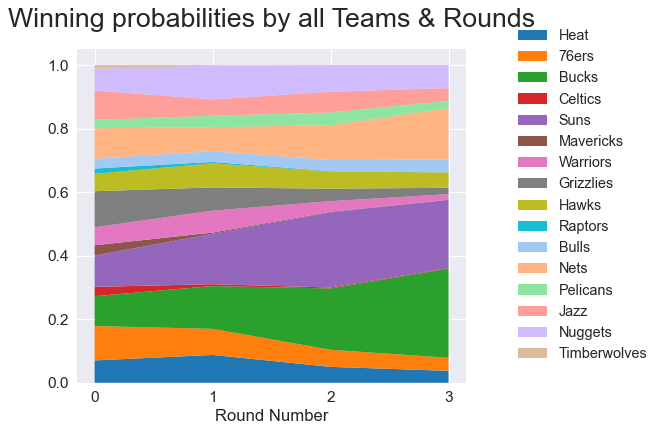

In [49]:
# plot the results: probabilities of winning for all teams at each round
fig = plotting(playoff.rounds_probs)